# COVET on Spatial Pancreas data - Statistics

Perform analysis per donor, consider one object per slide (2 donors) 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import scipy.sparse

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Load data

In [2]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
files   = ['s1_covet_niche_def_corr_per_fov.h5ad','s2_covet_niche_def_corr_per_fov.h5ad','s3_covet_niche_def_corr_per_fov.h5ad']

s1 = sc.read_h5ad(folder+files[0])
s1.obs["fov"] = s1.obs["fov"].astype(str) + "_s1"
s2 = sc.read_h5ad(folder+files[1])
s2.obs["fov"] = s2.obs["fov"].astype(str) + "_s2"
s3 = sc.read_h5ad(folder+files[2])
s3.obs["fov"] = s3.obs["fov"].astype(str) + "_s3"

adata = ad.concat([s1, s2, s3], join='outer',uns_merge='same',axis=0,pairwise=True) 
adata

/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial', 'spati

In [3]:
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'cov

In [5]:
adata.obs["total_counts_NegPrb"].sum() / adata.obs["total_counts"].sum() * 100

0.2659868567406363

In [4]:
adata.var_names

Index(['AATK', 'ABL1', 'ABL2', 'ACE', 'ACE2', 'ACKR1', 'ACKR3', 'ACKR4',
       'ACTA2', 'ACTG2',
       ...
       'NegPrb13', 'NegPrb14', 'NegPrb15', 'NegPrb16', 'NegPrb18', 'NegPrb19',
       'NegPrb20', 'NegPrb21', 'NegPrb22', 'NegPrb23'],
      dtype='object', length=979)

In [6]:
# Filter var_names to exclude genes starting with 'NegPrb'
filtered_genes = [gene for gene in adata.var_names if not gene.startswith('NegPrb')]

# Save the filtered gene list to a text file
output_file = "filtered_genes.txt"
with open(output_file, 'w') as f:
    f.write("\n".join(filtered_genes))

print(f"Filtered genes saved to {output_file}")

Filtered genes saved to filtered_genes.txt


In [32]:
x = pd.crosstab(adata.obs.donor,adata.obs.Niche_label)
x

Niche_label,Exocrine_acinar,Exocrine_ductal,Muc5b_ductal,Endocrine_exocrine,Endocrine,Connective_tissue
donor,,,,,,
Run5211_S1_ND,2108,25095,156,7769,6196,20136
Run5211_S1_T1D,10318,27399,44,1549,4992,2949
Run5211_S2_ND,25356,7872,72,7554,7649,111
Run5211_S2_T1D,8452,43691,59,20097,5348,160
Run5211_S3_ND,34711,3449,113,11381,1711,0
Run5211_S3_T1D,17782,66636,247,9610,4704,1251


/tmp/ipykernel_1817978/1619333948.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs.groupby(['Niche_label', 'condition']).size().unstack(fill_value=0)


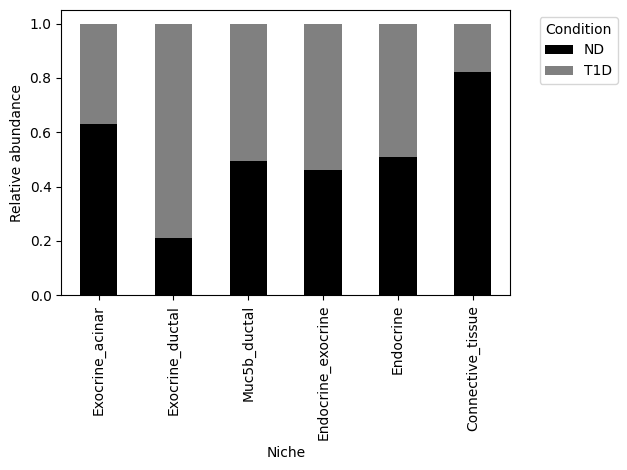

In [35]:
# Step 1: Group observations by 'condition' and count each 'CellTypes_max' entry
counts = adata.obs.groupby(['Niche_label', 'condition']).size().unstack(fill_value=0)
    
# Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
relative_abundance = counts.div(counts.sum(axis=1), axis=0)
    
#colors 
colors = ['#000000','#808080']
    
# Plot a stacked bar chart
ax = relative_abundance.plot(kind='bar', stacked=True,color=colors)
    
# Customize the plot (labels, title, etc.)
plt.xlabel('Niche')
plt.ylabel('Relative abundance')
plt.xticks(rotation=90)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1817978/3719573151.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs.groupby(['Niche_label', 'donor']).size().unstack(fill_value=0)


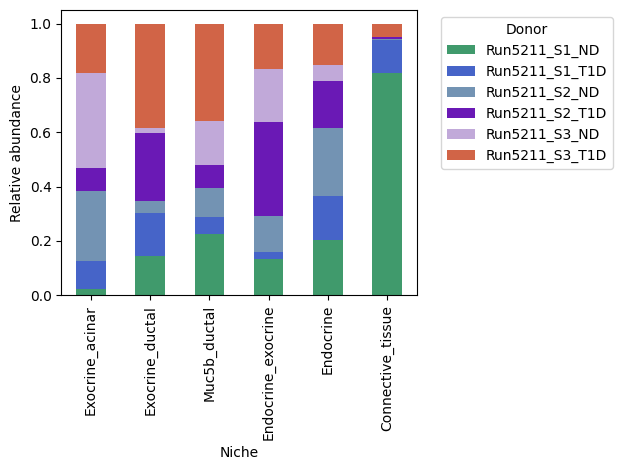

In [36]:
# Step 1: Group observations by 'condition' and count each 'CellTypes_max' entry
counts = adata.obs.groupby(['Niche_label', 'donor']).size().unstack(fill_value=0)
    
# Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
relative_abundance = counts.div(counts.sum(axis=1), axis=0)
    
#colors 
colors = adata.uns['Niche_label_colors']
    
# Plot a stacked bar chart
ax = relative_abundance.plot(kind='bar', stacked=True,color=colors)
    
# Customize the plot (labels, title, etc.)
plt.xlabel('Niche')
plt.ylabel('Relative abundance')
plt.xticks(rotation=90)
plt.legend(title='Donor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1817978/477775484.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs.groupby(['condition', 'Niche_label']).size().unstack(fill_value=0)


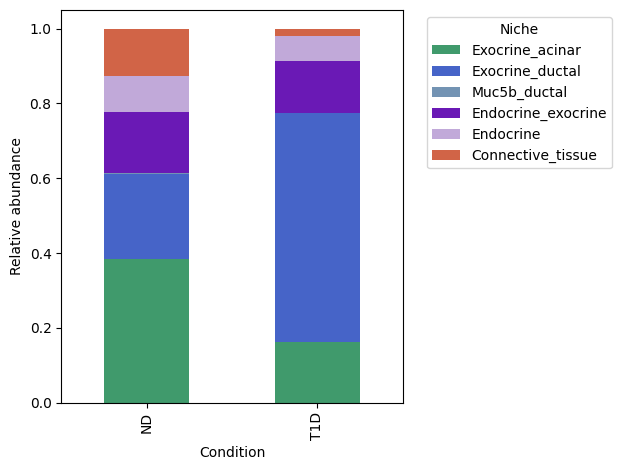

In [37]:
counts = adata.obs.groupby(['condition', 'Niche_label']).size().unstack(fill_value=0)    
relative_abundance = counts.div(counts.sum(axis=1), axis=0)

#colors 
colors = adata.uns['Niche_label_colors']

ax = relative_abundance.plot(kind='bar', stacked=True,color=colors)
plt.xlabel('Condition')
plt.ylabel('Relative abundance')
plt.xticks(rotation=90)
plt.legend(title='Niche', bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()      
plt.show()

In [38]:
# Step 1: Extract conditions and cell types
conditions = adata.obs['condition']
cell_types = adata.obs['Niche_label']

# Step 2: Calculate counts for each condition
counts = adata.obs.groupby(['condition', 'Niche_label']).size().unstack(fill_value=0)

# Split counts by conditions
condition1 = counts.loc['ND']  # Replace with your actual condition names
condition2 = counts.loc['T1D']

# Step 3: Perform Fisher’s exact test
fisher_results = pd.DataFrame(index=counts.columns, columns=['odds_ratio', 'p_value'])

for cell_type in counts.columns:
    # Create a 2x2 contingency table
    table = [
        [condition1[cell_type], condition2[cell_type]],  # Present in condition1 vs condition2
        [condition1.sum() - condition1[cell_type], condition2.sum() - condition2[cell_type]]  # Not present
    ]
    
    # Perform Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(table)
    fisher_results.loc[cell_type] = [odds_ratio, p_value]

print(fisher_results)

                   odds_ratio   p_value
Niche_label                            
Exocrine_acinar      3.234206       0.0
Exocrine_ductal      0.185183       0.0
Muc5b_ductal         1.360376  0.000058
Endocrine_exocrine    1.23037       0.0
Endocrine            1.490231       0.0
Connective_tissue    7.266326       0.0


/tmp/ipykernel_1817978/3792494232.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs.groupby(['condition', 'Niche_label']).size().unstack(fill_value=0)


### Interpretation of the Odds Ratio:

- Odds Ratio > 1: The cell type is more likely to occur in Condition 1 (ND) compared to Condition 2 (T1D).

- Odds Ratio = 1: The cell type is equally likely to occur in both conditions. There is no association between the cell type and the condition.
  
- Odds Ratio < 1:The cell type is less likely to occur in Condition 1 (ND) compared to Condition 2 (T1D).


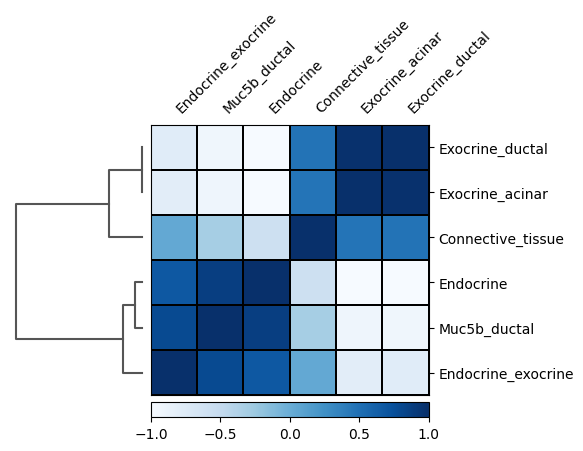

In [39]:
sc.tl.dendrogram(adata, "Niche_label")
sc.pl.correlation_matrix(adata, "Niche_label", cmap="Blues")

In [40]:
adata.obs

,fov,Area,AspectRatio,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,...,total_counts_NegPrb,log1p_total_counts_NegPrb,pct_counts_NegPrb,n_genes,cell_type_coarse,CellTypes_max,donor,cell_type,leiden_covet_0.2,Niche_label
1_1,1_s1,3038,2.05,-25945.777778,122127.000000,88,43,1830,13181,74,...,1,0.693147,0.418410,97,Acinar,Acinar_signal,Run5211_S1_T1D,Acinar_signal,11,Exocrine_ductal
2_1,1_s1,2507,1.34,-25566.777778,122125.000000,63,47,902,5621,82,...,1,0.693147,0.581395,73,Acinar,Acinar_basal,Run5211_S1_T1D,Acinar_basal,3,Endocrine
3_1,1_s1,7970,1.53,-25278.777778,122102.000000,142,93,1476,7846,134,...,3,1.386294,0.530035,197,Acinar,Endothelial,Run5211_S1_T1D,Endothelial,3,Endocrine
4_1,1_s1,5041,1.80,-24148.777778,122116.000000,115,64,931,7451,161,...,2,1.098612,0.595238,142,Acinar,Acinar_highEnz,Run5211_S1_T1D,Acinar_highEnz,9,Exocrine_ductal
5_1,1_s1,3835,1.17,-24070.777778,122108.000000,95,81,1016,7478,152,...,0,0.000000,0.000000,139,Acinar,Acinar_highEnz,Run5211_S1_T1D,Acinar_highEnz,9,Exocrine_ductal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7236_25,25_s3,1565,2.03,-17502.777778,-125771.888889,63,31,242,1027,63,...,0,0.000000,0.000000,23,Ductal,Beta,Run5211_S3_T1D,Beta,7,Exocrine_ductal
7237_25,25_s3,1432,1.69,-21233.777778,-125771.888889,54,32,27,336,23,...,0,0.000000,0.000000,10,Acinar,Alpha,Run5211_S3_T1D,Alpha,10,Exocrine_ductal
7239_25,25_s3,1788,1.91,-21493.777778,-125771.888889,61,32,393,4150,90,...,0,0.000000,0.000000,11,Ductal,Alpha,Run5211_S3_T1D,Alpha,10,Exocrine_ductal
7240_25,25_s3,1043,1.55,-21440.777778,-125772.888889,45,29,29,1079,32,...,0,0.000000,0.000000,14,Mast,Delta,Run5211_S3_T1D,Delta,10,Exocrine_ductal


In [41]:
folder

'/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'

In [42]:
adata.write(folder+'merged_covet_niche_def_corr_per_fov.h5ad')

### Var by distance plots

In [16]:
import squidpy as sq

In [43]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [44]:
adata.obs.CellTypes_max.cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'Macrophage',
       'Tcells'],
      dtype='object')

In [66]:
acinar_cells = ['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff']
adata_acinar = adata[adata.obs["CellTypes_max"].isin(acinar_cells)].copy()
adata_acinar

/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 201778 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'dendrogram_Niche_label', 'log1p', 'design_matrix'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30',

In [68]:
sq.tl.var_by_distance(
    adata=adata_acinar,
    groups='Acinar_highEnz',
    cluster_key="CellTypes_max",
    library_key="fov",
    covariates=["condition","donor"],
)

/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/squidpy/tl/_var_by_distance.py:262: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  design_matrix[anchor_point].replace(0, np.nan, inplace=True)
/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/squidpy/tl/_var_by_distance.py:262: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work b

In [69]:
adata.obsm['design_matrix']

,CellTypes_max,fov,Acinar_sigdiff,Acinar_sigdiff_raw,condition,donor,PRSS2,MT1X
1_1,Acinar_signal,1_s1,0.049439,77.369245,T1D,Run5211_S1_T1D,3.407315,0.499887
2_1,Acinar_basal,1_s1,0.046682,73.054774,T1D,Run5211_S1_T1D,3.195822,0.642466
3_1,Endothelial,1_s1,0.115760,181.157390,T1D,Run5211_S1_T1D,3.497738,0.739748
4_1,Acinar_highEnz,1_s1,0.031956,50.009999,T1D,Run5211_S1_T1D,3.199766,0.000000
5_1,Acinar_highEnz,1_s1,0.034011,53.225934,T1D,Run5211_S1_T1D,3.244478,0.387984
...,...,...,...,...,...,...,...,...
7236_25,Beta,25_s3,0.102020,159.655880,T1D,Run5211_S3_T1D,0.000000,1.877282
7237_25,Alpha,25_s3,0.029931,46.840154,T1D,Run5211_S3_T1D,0.000000,0.000000
7239_25,Alpha,25_s3,0.029143,45.607017,T1D,Run5211_S3_T1D,0.000000,0.000000
7240_25,Delta,25_s3,0.019726,30.870698,T1D,Run5211_S3_T1D,0.000000,0.000000


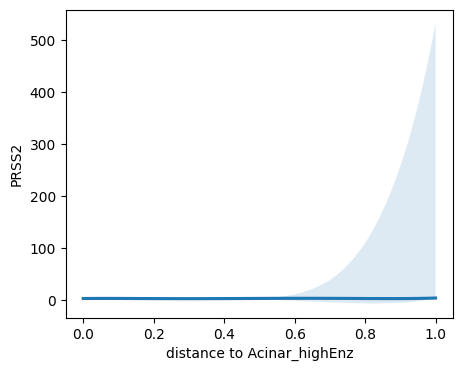

In [73]:
sq.pl.var_by_distance(
    adata=adata_acinar,
    design_matrix_key="design_matrix",
    var='PRSS2',
    anchor_key='Acinar_highEnz',
    color = acinar_cells,
    #covariate="condition",
    #line_palette=['grey','black'],
    show_scatter=False,
    figsize=(5, 4),
)

### Spatial statistics

In [75]:
sq.gr.spatial_neighbors(
    adata,
    library_key='fov',
    n_neighs=30,
    coord_type="generic",
    delaunay=True
)

In [76]:
adata_subset = adata[adata.obs.fov == "12_s1"].copy()
adata_subset

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'dendrogram_Niche_label', 'log1p', 'design_matrix', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sq

#### Co-ocurrence

In [86]:
sq.gr.co_occurrence(
    adata_subset,
    cluster_key="CellTypes_max",
)

100%|██████████| 1/1 [00:04<00:00,  4.02s/]


In [89]:
adata_subset.obs.CellTypes_max.cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'Macrophage',
       'Tcells'],
      dtype='object')

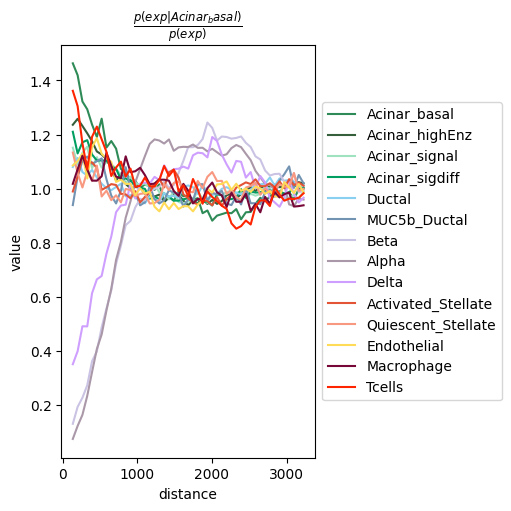

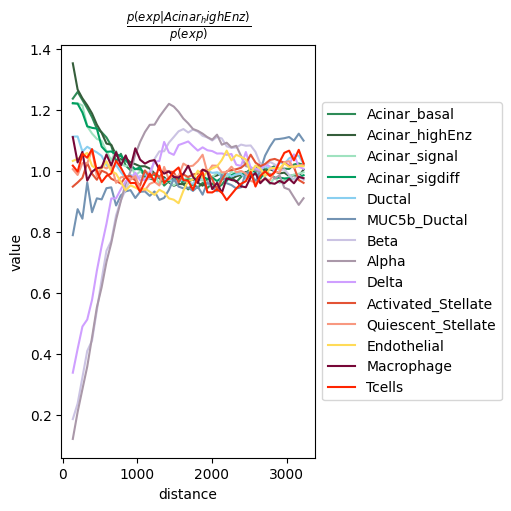

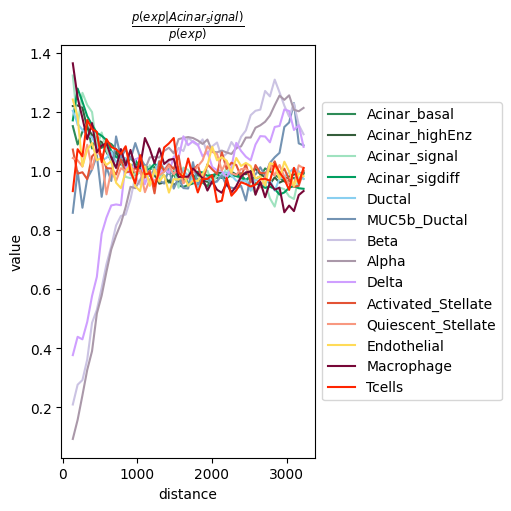

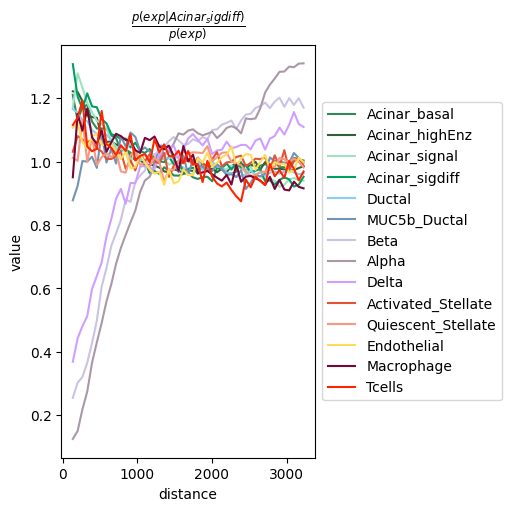

In [93]:
sq.pl.co_occurrence(
    adata_subset,
    cluster_key="CellTypes_max",
    clusters="Acinar_basal",
)
sq.pl.co_occurrence(
    adata_subset,
    cluster_key="CellTypes_max",
    clusters="Acinar_highEnz",
)
sq.pl.co_occurrence(
    adata_subset,
    cluster_key="CellTypes_max",
    clusters="Acinar_signal",
)
sq.pl.co_occurrence(
    adata_subset,
    cluster_key="CellTypes_max",
    clusters="Acinar_sigdiff",
)


#### Neighbors enrichment analysis

In [102]:
adata_nd = adata[adata.obs.condition == "ND"].copy()
adata_t1 = adata[adata.obs.condition == "T1D"].copy()

/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [103]:
adata_nd.obs_names_make_unique
adata_t1.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 225288 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'dendrogram_Niche_label', 'log1p', 'design_matrix', 'spatial_neighbors', 'CellTypes_m

In [110]:
adata_nd.obs.fov.unique(), adata_t1.obs.fov.unique() 

(['12_s1', '13_s1', '14_s1', '15_s1', '16_s1', ..., '20_s3', '21_s3', '22_s3', '23_s3', '24_s3']
 Length: 32
 Categories (32, object): ['12_s1', '12_s2', '13_s1', '13_s2', ..., '23_s1', '23_s3', '24_s1', '24_s3'],
 ['1_s1', '2_s1', '3_s1', '4_s1', '5_s1', ..., '11_s3', '12_s3', '13_s3', '14_s3', '25_s3']
 Length: 39
 Categories (39, object): ['1_s1', '1_s2', '1_s3', '2_s1', ..., '14_s3', '21_s2', '22_s2', '25_s3'])

In [111]:
sq.gr.nhood_enrichment(adata, cluster_key="CellTypes_max",library_key="fov")

100%|██████████| 1000/1000 [09:36<00:00,  1.73/s]


In [113]:
sq.gr.nhood_enrichment(adata, cluster_key="cell_type_coarse",library_key="fov")

100%|██████████| 1000/1000 [09:45<00:00,  1.71/s]


In [104]:
sq.gr.nhood_enrichment(adata_nd, cluster_key="CellTypes_max")

100%|██████████| 1000/1000 [00:12<00:00, 83.24/s]


In [105]:
sq.gr.nhood_enrichment(adata_t1, cluster_key="CellTypes_max")

100%|██████████| 1000/1000 [00:14<00:00, 70.73/s]


/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


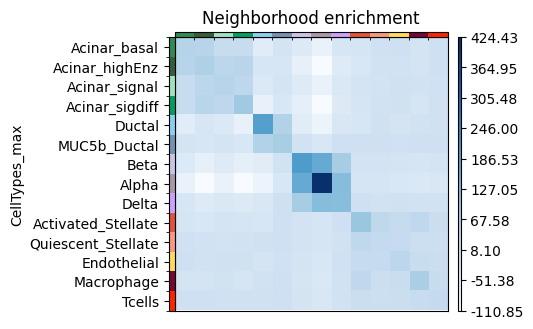

In [112]:
sq.pl.nhood_enrichment(
    adata,
    cluster_key="CellTypes_max",
    cmap='Blues',
    figsize=(3, 3),
    title="Neighborhood enrichment",
)

/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/envi/lib/python3.11/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


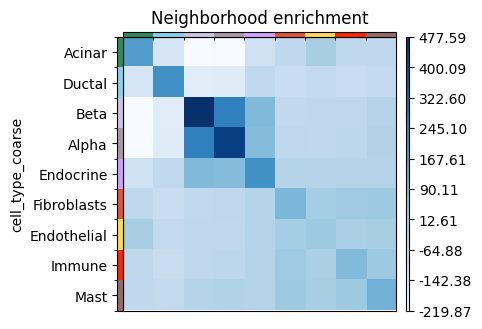

In [114]:
sq.pl.nhood_enrichment(
    adata,
    cluster_key="cell_type_coarse",
    cmap='Blues',
    figsize=(3, 3),
    title="Neighborhood enrichment",
)

#### Moran's I score

In [115]:
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=4,
    seed=3
)
#adata.uns["moranI"].head(50)

100%|██████████| 100/100 [24:12<00:00, 14.52s/] 


/tmp/ipykernel_1817978/2726971305.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = gene_expr_data.groupby('group').mean()


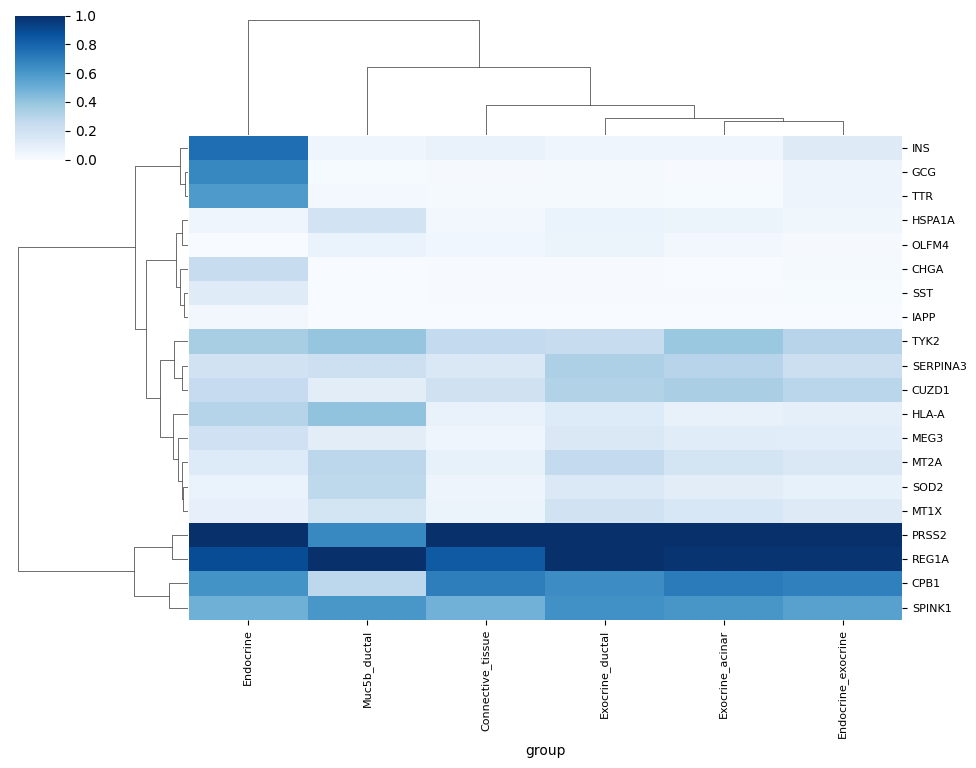

In [118]:
# 1. Subset the AnnData object to include only the genes you're interested in
genes_of_interest = adata.uns["moranI"].head(20).index  # Replace with your gene set

# 2. Extract expression data for the genes
# Use .raw if you want to use raw data, otherwise use adata.X (processed)

#values = adata[:, genes_of_interest].X

gene_expr_data = pd.DataFrame(
    adata[:, genes_of_interest].X, #.todense(),   # Extracts expression data for the specified genes
    index=adata.obs_names,           # Cell names
    columns=genes_of_interest        # Gene names
)

# 3. Group by a field in `obs` (e.g., cluster or cell type)
group_field = 'Niche_label'  # Replace with the field you want to group by, e.g., 'leiden', 'cell_type'
gene_expr_data['group'] = adata.obs[group_field]

# 4. Aggregate the gene expression data by the grouping field
grouped_data = gene_expr_data.groupby('group').mean()

# 5. Plot the clustermap with Seaborn
g = sns.clustermap(
    grouped_data.T,                     # Transpose to have genes on the x-axis, clusters on the y-axis
    standard_scale=1,                   # Standardize across the genes (columns)
    cmap='Blues',                     # Colormap for the heatmap
    figsize=(10, 8),                    # Set the figure size
    metric='euclidean',                 # Distance metric for clustering (can be 'euclidean', 'correlation', etc.)
    method='ward',                       # Clustering method (can be 'ward', 'average', 'single', etc.)
    xticklabels=True,                  # Show x-axis labels (genes)
    yticklabels=True                   # Show y-axis labels (groups)
)

# 6. Rotate the x-axis labels (gene names) for readability
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# 7. Optionally, adjust font size for better visibility
g.ax_heatmap.tick_params(axis='x', labelsize=8)  # Change font size for x-axis
g.ax_heatmap.tick_params(axis='y', labelsize=8)  # Change font size for y-axis